# The Objective

## Which is the better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

### Initialization

In [55]:
# Loading all the libraries
import pandas as pd
import scipy.stats as st
import math as mt
import random
from matplotlib import pyplot as plt
import numpy as np

### Load data

In [56]:
# Load the data files into different DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')

internet = pd.read_csv('/datasets/megaline_internet.csv')

messages = pd.read_csv('/datasets/megaline_messages.csv')

plans = pd.read_csv('/datasets/megaline_plans.csv')

users = pd.read_csv('/datasets/megaline_users.csv')


### Prepare the data

The users table (data on users):
        user_id — unique user identifier
        
        first_name — user's name
        
        last_name — user's last name
        
        age — user's age (years)
        
        reg_date — subscription date (dd, mm, yy)
        
        churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
        
        city — user's city of residence
        
        plan — calling plan name
        
        
The calls table (data on calls):

        id — unique call identifier
        
        call_date — call date
        
        duration — call duration (in minutes)
        
        user_id — the identifier of the user making the call
        
        
The messages table (data on texts):

        id — unique text message identifier
        
        message_date — text message date
        
        user_id — the identifier of the user sending the text
        
        
The internet table (data on web sessions):

        id — unique session identifier
        
        mb_used — the volume of data spent during the session (in megabytes)
        
        session_date — web session date
        
        user_id — user identifier
        
        
The plans table (data on the plans):

        plan_name — calling plan name
        
        usd_monthly_fee — monthly charge in US dollars
        
        minutes_included — monthly minute allowance
        
        messages_included — monthly text allowance
        
        mb_per_month_included — data volume allowance (in megabytes)
        
        usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
        
        usd_per_message — price per text after exceeding the package limits
        
        usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)



### Plans

In [57]:
# Print the general/summary information about the plans' DataFrame
print(plans.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [58]:
# Print a sample of data for plans
display(plans)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



I used info() to get a quick summary of the columns, missing values, and data types. There are only two plans, the usd_per_message and usd_per_minute are floats, the plan_name is type object and the rest are integers. Since the table is short I displayed the whole table. The internet included in the plan is in metabytes but the price of extra internet is in gigabytes, so below I will add a column to convert the mb_per_month_included to gigabytes. 

### Fix data

In [59]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


### Users

In [60]:
# Print the general/summary information about the users' DataFrame

print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [61]:

random.seed(15)
display(users.sample(5))


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
427,1427,Zofia,Brock,64,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-01-26,ultimate,NaN
137,1137,Allegra,Hopkins,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-10-02,surf,NaN
346,1346,Emmie,Gonzalez,59,"Tucson, AZ MSA",2018-04-26,ultimate,NaN
362,1362,Kenyetta,Mcknight,65,"Denver-Aurora-Lakewood, CO MSA",2018-01-18,surf,NaN
430,1430,Myung,Pugh,63,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-07,surf,NaN



Using info() again lets me see that the only column with missing data is churn_date which only has data if customers cancel their plan. Customers begining and ending service is within the natural cycle of the business so I am going to keep all users information. user_id and age columns are the only integer datatypes and the rest are objects. I will now change the reg_date and churn_date into datetime datatypes. The other issue is the city column. The format is city, state, country (also misspelled), and some of the users have multiple cities and states. 

#### Fix Data

In [62]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
print(users.info())
display(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


Now that the date is fixed. I am going to take a closer look at the cities. First by using unique():

In [63]:
print(users['city'].sort_values().unique())

['Albany-Schenectady-Troy, NY MSA' 'Albuquerque, NM MSA'
 'Atlanta-Sandy Springs-Roswell, GA MSA'
 'Austin-Round Rock-Georgetown, TX MSA' 'Bakersfield, CA MSA'
 'Baltimore-Columbia-Towson, MD MSA' 'Baton Rouge, LA MSA'
 'Birmingham-Hoover, AL MSA' 'Boston-Cambridge-Newton, MA-NH MSA'
 'Bridgeport-Stamford-Norwalk, CT MSA' 'Buffalo-Cheektowaga, NY MSA'
 'Cape Coral-Fort Myers, FL MSA' 'Charleston-North Charleston, SC MSA'
 'Charlotte-Concord-Gastonia, NC-SC MSA'
 'Chicago-Naperville-Elgin, IL-IN-WI MSA' 'Cincinnati, OH-KY-IN MSA'
 'Cleveland-Elyria, OH MSA' 'Colorado Springs, CO MSA' 'Columbia, SC MSA'
 'Columbus, OH MSA' 'Dallas-Fort Worth-Arlington, TX MSA'
 'Dayton-Kettering, OH MSA' 'Denver-Aurora-Lakewood, CO MSA'
 'Detroit-Warren-Dearborn, MI MSA' 'El Paso, TX MSA' 'Fresno, CA MSA'
 'Grand Rapids-Kentwood, MI MSA' 'Greensboro-High Point, NC MSA'
 'Houston-The Woodlands-Sugar Land, TX MSA'
 'Indianapolis-Carmel-Anderson, IN MSA' 'Jacksonville, FL MSA'
 'Kansas City, MO-KS MSA' 'Kno

The column name of 'city' is not representative of the data so I will change the name to 'region'. All of the cities are seperated from states by a comma, so I can use that to add new columns for state and city. I will also fix the spelling of 'USA'. 

In [64]:
users.rename(columns = {'city': 'region'}, inplace = True)
users['region'] = [sub.replace('MSA', 'USA') for sub in users['region']]
city = []
state_country = []
for row in users['region']:
    add_city = row.split(',')
    city.append(add_city[0])
    state_country.append(add_city[1])
users['city'] = city
display(users.head())


,user_id,first_name,last_name,age,region,reg_date,plan,churn_date,city
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA USA",2018-12-24,ultimate,NaT,Atlanta-Sandy Springs-Roswell
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA USA",2018-08-13,surf,NaT,Seattle-Tacoma-Bellevue
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV USA",2018-10-21,surf,NaT,Las Vegas-Henderson-Paradise
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK USA",2018-01-28,surf,NaT,Tulsa
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA USA",2018-05-23,surf,NaT,Seattle-Tacoma-Bellevue


In [65]:
state = []
for item in state_country:
    add_state = item.split(' ')
    state.append(add_state[1])
users['state'] = state
display(users.head())

,user_id,first_name,last_name,age,region,reg_date,plan,churn_date,city,state
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA USA",2018-12-24,ultimate,NaT,Atlanta-Sandy Springs-Roswell,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA USA",2018-08-13,surf,NaT,Seattle-Tacoma-Bellevue,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV USA",2018-10-21,surf,NaT,Las Vegas-Henderson-Paradise,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK USA",2018-01-28,surf,NaT,Tulsa,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA USA",2018-05-23,surf,NaT,Seattle-Tacoma-Bellevue,WA


#### Enrich Data


Here I am going to check the percentage of each plan. If the sample contains an equal or close to equal amount of people for each plan it will be easier to compare the plans. 

In [66]:
per_ultimate = users[users['plan'] == 'ultimate']['plan'].count() / 500 *100
per_surf = users[users['plan'] == 'surf']['plan'].count() /500 *100
print('ultimate: ', per_ultimate)
print('surf: ', per_surf)

ultimate:  32.2
surf:  67.80000000000001


The ultimate plan only accounts for one-third of the sample. 

### Calls

In [67]:
# Print the general/summary information about the calls' DataFrame
print(calls.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [68]:
# Print a sample of data for calls
display(calls.sample(5))


,id,user_id,call_date,duration
26456,1100_13,1100,2018-12-20,4.30
133352,1483_149,1483,2018-06-26,8.27
87949,1322_57,1322,2018-08-28,7.68
30919,1115_553,1115,2018-12-12,0.00
111703,1392_113,1392,2018-11-11,5.69



Again I will change the call_date to datetime datatype. 

#### Fix data

In [69]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
display(calls.head())
print(calls.info())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None


#### Enrich data


I will need to know the total minutes each customer has per month. First I will create a new column and extract the month from the call_date. Then I can use the groupby() method to get the total minutes of the calls per customer per month. 

In [70]:
calls['month'] = calls['call_date'].dt.month
display(calls.head())

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


### Messages

In [71]:
# Print the general/summary information about the messages' DataFrame
print(messages.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [72]:
# Print a sample of data for messages
display(messages.sample(5))


,id,user_id,message_date
9510,1069_631,1069,2018-11-09
53139,1339_273,1339,2018-09-30
46279,1316_88,1316,2018-09-21
58947,1374_121,1374,2018-06-18
66442,1433_382,1433,2018-12-25



I will change message_date to datetime datatype. 

#### Fix data

In [73]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
print(messages.info())
print(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


#### Enrich data


I will need to know how many messages each customer sends per month. I will add a month column, then group by user_id and month. 

In [74]:
messages['month'] = messages['message_date'].dt.month
messages_per_month = messages.groupby(['user_id', 'month'])
display(messages_per_month.head())


,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76001,1497_3,1497,2018-12-25,12
76002,1497_32,1497,2018-12-14,12
76003,1497_45,1497,2018-12-11,12
76004,1497_47,1497,2018-12-19,12


### Internet

In [75]:
# Print the general/summary information about the internet DataFrame
print(internet.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [76]:
# Print a sample of data for the internet traffic
display(internet.sample(5))


,id,user_id,session_date,mb_used
42268,1187_445,1187,2018-06-15,400.70
71718,1334_286,1334,2018-08-20,660.91
103612,1495_235,1495,2018-12-30,378.88
12133,1059_241,1059,2018-06-10,8.34
60600,1276_84,1276,2018-12-18,104.53



I will change the session datatype from object to datetime. 

#### Fix data

In [77]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


#### Enrich data


I will need to know how much internet is used by each customer per month. I will also add a new column for gb used each month. 

In [78]:
internet['month'] = internet['session_date'].dt.month
internet_per_month = internet.groupby(['user_id', 'month'])

internet['gb_used'] = internet['mb_used']/1024
display(internet.head())

,id,user_id,session_date,mb_used,month,gb_used
0,1000_13,1000,2018-12-29,89.86,12,0.087754
1,1000_204,1000,2018-12-31,0.00,12,0.000000
2,1000_379,1000,2018-12-28,660.40,12,0.644922
3,1000_413,1000,2018-12-26,270.99,12,0.264639
4,1000_442,1000,2018-12-27,880.22,12,0.859590


### Study plan conditions

In [79]:
# Print out the plan conditions and make sure they are clear for you
display(plans)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


### Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [80]:
# Calculate the number of calls made by each user per month. Save the result.

minutes_per_month = calls.groupby(['user_id', 'month'])
calls_count = minutes_per_month.agg({'call_date': 'count'})
print(calls_count.head())

               call_date
user_id month           
1000    12            16
1001    8             27
        9             49
        10            65
        11            64


In [81]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_total = minutes_per_month.agg({'duration': 'sum'})
avg_duration =  minutes_per_month.agg({'duration': 'mean'})
print(minutes_total.head())
print(avg_duration.head())

               duration
user_id month          
1000    12       116.83
1001    8        171.14
        9        297.69
        10       374.11
        11       404.59
               duration
user_id month          
1000    12     7.301875
1001    8      6.338519
        9      6.075306
        10     5.755538
        11     6.321719


In [82]:
# Calculate the number of messages sent by each user per month. Save the result.
total_messages = messages_per_month.agg({'id': 'count'})
print(total_messages.head())

               id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36


In [83]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
total_internet = internet_per_month.agg({'gb_used': 'sum'})
print(total_internet.head())

                 gb_used
user_id month           
1000    12      1.856904
1001    8       6.756982
        9      13.002754
        10     21.807119
        11     18.070605


Merging the data from the aggregate functions will give a table of how each user is using their plan each month. 

In [84]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_per_month = pd.concat([calls_count, minutes_total, total_messages, total_internet], axis = 1)
user_per_month['avg_duration'] = avg_duration

print(user_per_month.info())
display(user_per_month.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1499, 12)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   call_date     2258 non-null   float64
 1   duration      2258 non-null   float64
 2   id            1806 non-null   float64
 3   gb_used       2277 non-null   float64
 4   avg_duration  2258 non-null   float64
dtypes: float64(5)
memory usage: 116.8 KB
None


call_date  duration    id    gb_used  avg_duration
user_id month                                                    
1000    12          16.0    116.83  11.0   1.856904      7.301875
1001    8           27.0    171.14  30.0   6.756982      6.338519
        9           49.0    297.69  44.0  13.002754      6.075306
        10          65.0    374.11  53.0  21.807119      5.755538
        11          64.0    404.59  36.0  18.070605      6.321719

In [85]:
# Add the plan information
column_names = {'call_date': 'call_count', 'duration': 'total_minutes', 'id': 'message_count', 'mb_used': 'mb_used'}
user_per_month = user_per_month.rename(columns = column_names)
user_per_month_rows = user_per_month
ultimate_plan = users[users['plan'] == 'ultimate']
print(ultimate_plan.head())
ultimate_users = user_per_month_rows.query('user_id in @ultimate_plan.user_id')
surf_users = user_per_month_rows.query('user_id not in @ultimate_plan.user_id')
display(ultimate_users.head())
display(surf_users.head())

    user_id first_name last_name  age                                  region  \
0      1000   Anamaria     Bauer   45   Atlanta-Sandy Springs-Roswell, GA USA   
6      1006     Jesusa  Bradford   73  San Francisco-Oakland-Berkeley, CA USA   
8      1008      Emely   Hoffman   53       Orlando-Kissimmee-Sanford, FL USA   
11     1011     Halina     Henry   73                Cleveland-Elyria, OH USA   
13     1013    Nicolas    Snider   50                       Knoxville, TN USA   

     reg_date      plan churn_date                            city state  
0  2018-12-24  ultimate        NaT   Atlanta-Sandy Springs-Roswell    GA  
6  2018-11-27  ultimate 2018-12-18  San Francisco-Oakland-Berkeley    CA  
8  2018-08-03  ultimate        NaT       Orlando-Kissimmee-Sanford    FL  
11 2018-01-18  ultimate        NaT                Cleveland-Elyria    OH  
13 2018-12-01  ultimate        NaT                       Knoxville    TN  


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1000    12           16.0         116.83           11.0   1.856904   
1006    11            2.0           9.32           15.0   2.019893   
        12            9.0          54.79          139.0  31.366035   
1008    10           71.0         450.21           21.0  16.706045   
        11           63.0         422.81           37.0  23.121797   

               avg_duration  
user_id month                
1000    12         7.301875  
1006    11         4.660000  
        12         6.087778  
1008    10         6.340986  
        11         6.711270

call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1001    8            27.0         171.14           30.0   6.756982   
        9            49.0         297.69           44.0  13.002754   
        10           65.0         374.11           53.0  21.807119   
        11           64.0         404.59           36.0  18.070605   
        12           56.0         392.93           44.0  18.915215   

               avg_duration  
user_id month                
1001    8          6.338519  
        9          6.075306  
        10         5.755538  
        11         6.321719  
        12         7.016607

In [86]:
ult_cost = []
for item in ultimate_users.index:
    ult_cost.append(70)
ultimate_users['plan_cost'] = ult_cost
surf_cost = []
for item in surf_users.index:
    surf_cost.append(20)
surf_users['plan_cost'] = surf_cost
display(ultimate_users.head())
display(surf_users.head())

/tmp/ipykernel_59/405073534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users['plan_cost'] = ult_cost
/tmp/ipykernel_59/405073534.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users['plan_cost'] = surf_cost


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1000    12           16.0         116.83           11.0   1.856904   
1006    11            2.0           9.32           15.0   2.019893   
        12            9.0          54.79          139.0  31.366035   
1008    10           71.0         450.21           21.0  16.706045   
        11           63.0         422.81           37.0  23.121797   

               avg_duration  plan_cost  
user_id month                           
1000    12         7.301875         70  
1006    11         4.660000         70  
        12         6.087778         70  
1008    10         6.340986         70  
        11         6.711270         70

call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1001    8            27.0         171.14           30.0   6.756982   
        9            49.0         297.69           44.0  13.002754   
        10           65.0         374.11           53.0  21.807119   
        11           64.0         404.59           36.0  18.070605   
        12           56.0         392.93           44.0  18.915215   

               avg_duration  plan_cost  
user_id month                           
1001    8          6.338519         20  
        9          6.075306         20  
        10         5.755538         20  
        11         6.321719         20  
        12         7.016607         20

In [87]:
minutes_revenue = []
messages_revenue = []
internet_revenue = []
for each in ultimate_users['total_minutes']:
    if each > 3000:
        minutes = each - 3000
        min_cost = minutes * 0.01
        minutes_revenue.append(min_cost)
    else: 
        minutes_revenue.append(0)
ultimate_users['minutes_revenue'] = minutes_revenue
display(ultimate_users.head())

/tmp/ipykernel_59/901298447.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users['minutes_revenue'] = minutes_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1000    12           16.0         116.83           11.0   1.856904   
1006    11            2.0           9.32           15.0   2.019893   
        12            9.0          54.79          139.0  31.366035   
1008    10           71.0         450.21           21.0  16.706045   
        11           63.0         422.81           37.0  23.121797   

               avg_duration  plan_cost  minutes_revenue  
user_id month                                            
1000    12         7.301875         70                0  
1006    11         4.660000         70                0  
        12         6.087778         70                0  
1008    10         6.340986         70                0  
        11         6.711270         70                0

In [88]:
for each in ultimate_users['message_count']:
    if each > 1000:
        message = each - 1000
        mess_cost = minutes * 0.01
        messages_revenue.append(mess_cost)
    else: 
        messages_revenue.append(0)
ultimate_users['messages_revenue'] = messages_revenue
display(ultimate_users.head())

/tmp/ipykernel_59/3674733045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users['messages_revenue'] = messages_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1000    12           16.0         116.83           11.0   1.856904   
1006    11            2.0           9.32           15.0   2.019893   
        12            9.0          54.79          139.0  31.366035   
1008    10           71.0         450.21           21.0  16.706045   
        11           63.0         422.81           37.0  23.121797   

               avg_duration  plan_cost  minutes_revenue  messages_revenue  
user_id month                                                              
1000    12         7.301875         70                0                 0  
1006    11         4.660000         70                0                 0  
        12         6.087778         70                0                 0  
1008    10         6.340986         70                0                 0  
        11         6.711270         70                0                 0

In [89]:

for each in ultimate_users['gb_used']:
    if each > 30:
        gb = mt.ceil((each - 30))
        gb_rev = gb * 7
        internet_revenue.append(gb_rev)
    else: 
        internet_revenue.append(0)

ultimate_users['internet_revenue'] = internet_revenue
display(ultimate_users.head())
display(ultimate_users.describe())

/tmp/ipykernel_59/457877408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users['internet_revenue'] = internet_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1000    12           16.0         116.83           11.0   1.856904   
1006    11            2.0           9.32           15.0   2.019893   
        12            9.0          54.79          139.0  31.366035   
1008    10           71.0         450.21           21.0  16.706045   
        11           63.0         422.81           37.0  23.121797   

               avg_duration  plan_cost  minutes_revenue  messages_revenue  \
user_id month                                                               
1000    12         7.301875         70                0                 0   
1006    11         4.660000         70                0                 0   
        12         6.087778         70                0                 0   
1008    10         6.340986         70                0                 0   
        11         6.711270         70                0                 0   

               internet_revenue  
user_id month                    
1000    12                    0  
1006    11                    0  
        12                   14  
1008    10                    0  
        11                    0

,call_count,total_minutes,message_count,gb_used,avg_duration,plan_cost,minutes_revenue,messages_revenue,internet_revenue
count,713.000000,713.000000,584.000000,719.000000,713.000000,720.0,720.0,720.0,720.000000
mean,61.221599,410.180954,46.296233,16.834612,6.678253,70.0,0.0,0.0,2.313889
std,32.855296,224.745705,32.942118,7.647479,0.936871,0.0,0.0,0.0,11.395108
min,2.000000,0.000000,1.000000,0.227705,0.000000,70.0,0.0,0.0,0.000000
25%,37.000000,247.970000,21.000000,12.374150,6.206875,70.0,0.0,0.0,0.000000
50%,61.000000,399.980000,41.000000,16.468213,6.687698,70.0,0.0,0.0,0.000000
75%,80.000000,534.820000,66.000000,20.532378,7.245000,70.0,0.0,0.0,0.000000
max,191.000000,1292.090000,166.000000,45.503252,10.696000,70.0,0.0,0.0,112.000000


The process of adding the revenue from messages, calls, and internet will now be applied to the surf users. 

In [90]:
s_minutes_revenue = []
s_messages_revenue = []
s_internet_revenue = []
for each in surf_users['total_minutes']:
    if each > 500:
        minutes = each - 500
        min_cost = minutes * 0.03
        s_minutes_revenue.append(min_cost)
    else: 
        s_minutes_revenue.append(0)
surf_users['minutes_revenue'] = s_minutes_revenue
display(surf_users.head())

/tmp/ipykernel_59/3877824727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users['minutes_revenue'] = s_minutes_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1001    8            27.0         171.14           30.0   6.756982   
        9            49.0         297.69           44.0  13.002754   
        10           65.0         374.11           53.0  21.807119   
        11           64.0         404.59           36.0  18.070605   
        12           56.0         392.93           44.0  18.915215   

               avg_duration  plan_cost  minutes_revenue  
user_id month                                            
1001    8          6.338519         20              0.0  
        9          6.075306         20              0.0  
        10         5.755538         20              0.0  
        11         6.321719         20              0.0  
        12         7.016607         20              0.0

In [91]:
for each in surf_users['message_count']:
    if each > 50:
        message = each - 50
        mess_cost = minutes * 0.03
        s_messages_revenue.append(mess_cost)
    else: 
        s_messages_revenue.append(0)
surf_users['messages_revenue'] = s_messages_revenue
display(surf_users.head())

/tmp/ipykernel_59/1598288076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users['messages_revenue'] = s_messages_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1001    8            27.0         171.14           30.0   6.756982   
        9            49.0         297.69           44.0  13.002754   
        10           65.0         374.11           53.0  21.807119   
        11           64.0         404.59           36.0  18.070605   
        12           56.0         392.93           44.0  18.915215   

               avg_duration  plan_cost  minutes_revenue  messages_revenue  
user_id month                                                              
1001    8          6.338519         20              0.0            0.0000  
        9          6.075306         20              0.0            0.0000  
        10         5.755538         20              0.0            2.3409  
        11         6.321719         20              0.0            0.0000  
        12         7.016607         20              0.0            0.0000

In [92]:
for each in surf_users['gb_used']:
    if each > 15:
        gb = mt.ceil((each - 15))
        gb_rev = gb * 10
        s_internet_revenue.append(gb_rev)
    else: 
        s_internet_revenue.append(0)

surf_users['internet_revenue'] = s_internet_revenue
display(surf_users.head())
display(surf_users.describe())

/tmp/ipykernel_59/331975430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users['internet_revenue'] = s_internet_revenue


call_count  total_minutes  message_count    gb_used  \
user_id month                                                        
1001    8            27.0         171.14           30.0   6.756982   
        9            49.0         297.69           44.0  13.002754   
        10           65.0         374.11           53.0  21.807119   
        11           64.0         404.59           36.0  18.070605   
        12           56.0         392.93           44.0  18.915215   

               avg_duration  plan_cost  minutes_revenue  messages_revenue  \
user_id month                                                               
1001    8          6.338519         20              0.0            0.0000   
        9          6.075306         20              0.0            0.0000   
        10         5.755538         20              0.0            2.3409   
        11         6.321719         20              0.0            0.0000   
        12         7.016607         20              0.0            0.0000   

               internet_revenue  
user_id month                    
1001    8                     0  
        9                     0  
        10                   70  
        11                   40  
        12                   40

,call_count,total_minutes,message_count,gb_used,avg_duration,plan_cost,minutes_revenue,messages_revenue,internet_revenue
count,1545.000000,1545.000000,1222.000000,1558.000000,1545.000000,1573.0,1573.000000,1573.000000,1573.000000
mean,60.895793,412.097890,40.109656,16.325881,6.756734,20.0,1.464708,0.505980,38.652257
std,31.268044,216.797727,33.035500,7.699886,1.096317,0.0,3.302048,0.963858,54.456269
min,1.000000,0.000000,1.000000,0.090146,0.000000,20.0,0.000000,0.000000,0.000000
25%,40.000000,262.780000,16.000000,11.902300,6.185048,20.0,0.000000,0.000000,0.000000
50%,60.000000,405.710000,32.000000,16.527178,6.744565,20.0,0.000000,0.000000,20.000000
75%,80.000000,546.230000,54.000000,20.546738,7.278750,20.0,1.310400,0.000000,60.000000
max,205.000000,1431.220000,266.000000,69.269131,18.750000,20.0,27.936600,2.340900,550.000000


In [93]:
# Calculate the monthly revenue for each user
ultimate_users['total_revenue'] = ultimate_users['minutes_revenue'] + ultimate_users['messages_revenue'] + ultimate_users['internet_revenue'] + ultimate_users['plan_cost']
display(ultimate_users['total_revenue'].head())
surf_users['total_revenue'] = surf_users['minutes_revenue'] + surf_users['messages_revenue'] + surf_users['internet_revenue'] + surf_users['plan_cost']
display(surf_users['total_revenue'].head())

/tmp/ipykernel_59/1842816850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimate_users['total_revenue'] = ultimate_users['minutes_revenue'] + ultimate_users['messages_revenue'] + ultimate_users['internet_revenue'] + ultimate_users['plan_cost']


user_id  month
1000     12       70
1006     11       70
         12       84
1008     10       70
         11       70
Name: total_revenue, dtype: int64

/tmp/ipykernel_59/1842816850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surf_users['total_revenue'] = surf_users['minutes_revenue'] + surf_users['messages_revenue'] + surf_users['internet_revenue'] + surf_users['plan_cost']


user_id  month
1001     8        20.0000
         9        20.0000
         10       92.3409
         11       60.0000
         12       60.0000
Name: total_revenue, dtype: float64

### Study user behaviour

#### Calls

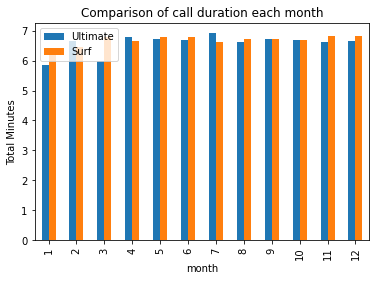

In [94]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.
u_monthly_avg = ultimate_users.groupby('month').mean()
s_monthly_avg = surf_users.groupby('month').mean()
monthly_avg = u_monthly_avg.merge(s_monthly_avg, right_on = 'month', left_on = 'month')
monthly_avg[['avg_duration_x', 'avg_duration_y']].plot(kind = 'bar',ylabel = 'Total Minutes', title = 'Comparison of call duration each month')
plt.legend(['Ultimate', 'Surf'])

plt.show()

Users in both plans have similar call durations. 

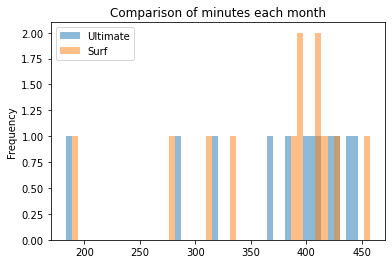

In [95]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
monthly_avg[['total_minutes_x', 'total_minutes_y']].plot(kind = 'hist',
                                                         ylabel = 'Total Minutes', 
                                                         title = 'Comparison of minutes each month', 
                                                         alpha = 0.5, bins = 50)
plt.legend(['Ultimate', 'Surf'])
plt.show()

Neither plans have a normal distribution of total minutes, but it seems to be skewed to the left. 

In [96]:
# Calculate the mean and the variance of the monthly call duration
print('Ultimate:', monthly_avg['avg_duration_x'].mean(), np.var(monthly_avg['avg_duration_x']))
print('Surf:', monthly_avg['avg_duration_y'].mean(), np.var(monthly_avg['avg_duration_y']))


Ultimate: 6.581388143643348 0.09351483263219192
Surf: 6.682611722485064 0.024926215246246483


Both plans have similar avgerages and the ultimate plan has a higher variance for call duration. 

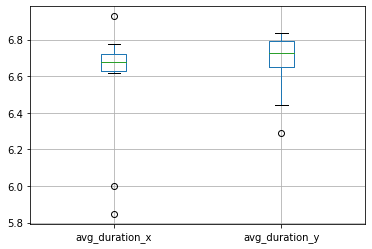

In [97]:
# Plot a boxplot to visualize the distribution of the monthly call duration
monthly_avg[['avg_duration_x', 'avg_duration_y']].boxplot()
plt.show()


The ultimate plan users are shown first, although there are more and farther outliers on the boxplot, the interquartile range is smaller. 

#### Messages

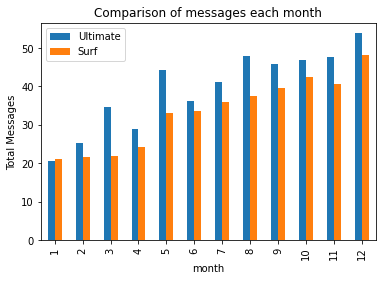

In [98]:
# Compare the number of messages users of each plan tend to send each month
monthly_avg[['message_count_x', 'message_count_y']].plot(kind = 'bar',
                                                         ylabel = 'Total Messages', 
                                                         title = 'Comparison of messages each month')
plt.legend(['Ultimate', 'Surf'])

plt.show()


Users on the ultimate plan generally text more each month. 

In [99]:
print('Ultimate:', monthly_avg['message_count_x'].mean(), np.var(monthly_avg['message_count_x']))
print('Surf:', monthly_avg['message_count_y'].mean(), np.var(monthly_avg['message_count_y']))

Ultimate: 39.47232523405716 97.76741194313193
Surf: 33.30976679539808 77.24233718034748


The averages of each plan is similar with ultimate being slightly higher, but the variance for ultimate users is a lot higher at 97.77. Although the sample size for the ultimate plan is lower which can cause higher variance. 

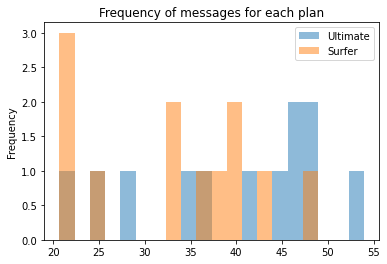

In [100]:
monthly_avg[['message_count_x', 'message_count_y']].plot(kind = 'hist', 
                                                        title = 'Frequency of messages for each plan', 
                                                        bins = 20, 
                                                        alpha = 0.5)
plt.legend(['Ultimate', 'Surfer'])
plt.show()


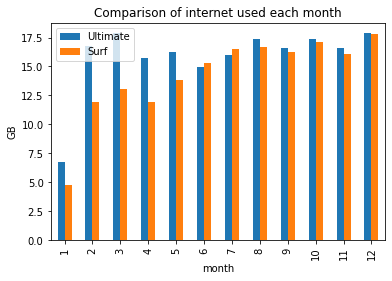

In [101]:
# Compare the amount of internet traffic consumed by users per plan
monthly_avg[['gb_used_x', 'gb_used_y']].plot(kind = 'bar',ylabel = 'GB', title = 'Comparison of internet used each month')
plt.legend(['Ultimate', 'Surf'])

plt.show()

Users on the ultimate plan generally use more internet then users on the surf plan for the first 5 months of the year but users on the surf plan increase to be level with users on the ultimate plan.  

#### Internet

In [102]:
print('Ultimate:', monthly_avg['gb_used_x'].mean(), np.var(monthly_avg['gb_used_x']))
print('Surf:', monthly_avg['gb_used_y'].mean(), np.var(monthly_avg['gb_used_y']))

Ultimate: 15.846271234979925 8.214285012938397
Surf: 14.262930910216896 11.91086846813702


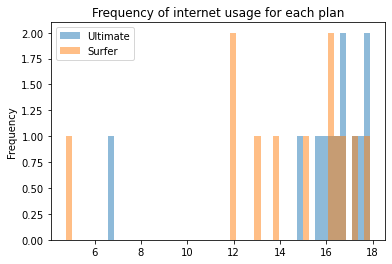

In [103]:
monthly_avg[['gb_used_x', 'gb_used_y']].plot(kind = 'hist', 
                                                        title = 'Frequency of internet usage for each plan', 
                                                        bins = 50, 
                                                        alpha = 0.5)
plt.legend(['Ultimate', 'Surfer'])
plt.show()


Looking at the histogram above we can see there are more ultimate plan users that use a higher amount of internet. 

### Revenue

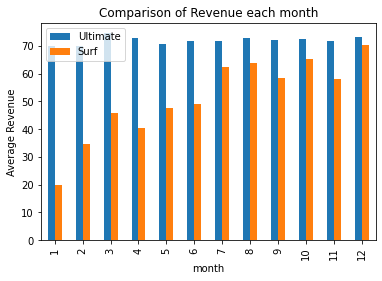

In [104]:
monthly_avg[['total_revenue_x', 'total_revenue_y']].plot(kind = 'bar',ylabel = 'Average Revenue', title = 'Comparison of Revenue each month')
plt.legend(['Ultimate', 'Surf'])

plt.show()

The monthly average revenue is higher for the ultimate plan every month. 

Ultimate: 72.01106825881764 1.7056240167926762
Surf: 51.33285558431853 197.24178293433133


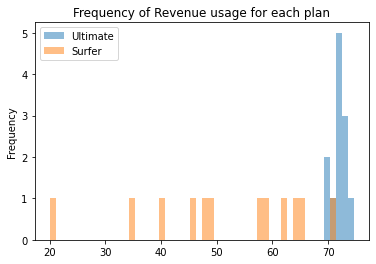

In [105]:
print('Ultimate:', monthly_avg['total_revenue_x'].mean(), np.var(monthly_avg['total_revenue_x']))
print('Surf:', monthly_avg['total_revenue_y'].mean(), np.var(monthly_avg['total_revenue_y']))
monthly_avg[['total_revenue_x', 'total_revenue_y']].plot(kind = 'hist', 
                                                        title = 'Frequency of Revenue usage for each plan', 
                                                        bins = 50, 
                                                        alpha = 0.5)
plt.legend(['Ultimate', 'Surfer'])
plt.show()



Overall the revenue for the ultimate plan is higher and has a small variance, the surf plan has a high variance so the revenue month-to-month has changed a lot. 

### Test statistical hypotheses


I want to see if the average revenue from users of Ultimate and Surf are the same or different. 
The null hypothesis will be: The average revenue of the plans are the same.
The alternative hypothesis is that the average revenue of the plans are different. 
I am going to set the critical statistical significance level to 0.05. 
Above I had compared the variance between the the two plans, the surf plan has a larger variance so the equal_var will be set to False. 

In [106]:
# Test the hypotheses
alpha = 0.05 # your code: set a critical statistical significance level

results = st.ttest_ind(monthly_avg['total_revenue_x'], monthly_avg['total_revenue_y'], equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.000476724021214518
We reject the null hypothesis


It can be concluded that the plans have different average revenues. In the charts above, it was clear that the ultimate plan had a higher average revenue. 


I want to compare the average revenue from users in the NY-NJ area to users in other regions. I will first need to prepare the data by grouping the revenue data by city and adding the revenue of both plans for each city. 

In [107]:
ny_region = users[users['city'] == 'New York-Newark-Jersey City']
all_users = pd.concat([ultimate_users, surf_users])

ny_users = all_users.query('user_id in @ny_region.user_id')
other_users = all_users.query('user_id not in @ny_region.user_id')
print('NY-NJ:', ny_users['total_revenue'].mean(), np.var(ny_users['total_revenue']))
print('Other:', other_users['total_revenue'].mean(), np.var(other_users['total_revenue']))


NY-NJ: 59.78453925729443 1891.079619901642
Other: 65.18116925887264 2215.1140308340077



The null hypothesis will be that both regions' average revenue is statistically the same. 
The alternative hypothesis is that they are different. 

In [108]:
# Test the hypotheses
alpha = 0.05 # your code: set a critical statistical significance level

results = st.ttest_ind(ny_users['total_revenue'], other_users['total_revenue'], equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value: 0.030442760524132577
We reject the null hypothesis


The average revenue of the regions are significantly different with users in NY-NJ having a lower average revenue. 

### General conclusions

Starting off in section 1.6.2 I had calculated that the number of ultimate users in the sample was only 1/3 of the overall sample. Initially I had concerns if that would skew the data, however, going through the project I saw users on the ultimate plan consistently had a smaller variance in most all areas. 

The main assumption throughout this project is that the sample is representative of all the customers in the US. 

Looking in to plan behaviors I saw that average call duration was similar but ultimate users had a larger variance. 
Ultimate users generally sent more messages and both plans increased throughout the year. 
Ultimate useres generally used more internet.

Average monthly revenue was higher from the ultimate plan than the surf plan. 
I used a t-test to determing if the difference was significant, and it was. 

NY-NJ had a smaller average monthly revenue compared to the rest of the cities. I used a t-test to determine if the difference was significant and it was. 

While I was charting the plan use behavior I noticed a trend of use increasing throughout the year. Further study could show if the increase was a result of the business growing each month. 


 Based on this data the ultimate plan generates more revenue. 